In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib as mpl
import metpy.calc as mpcalc
from metpy.units import units
import pytz
from datetime import datetime, timedelta

mpl.rcParams['timezone'] = 'US/Pacific'
mpl.rcParams['text.latex.preamble'] = [r'\boldmath']

In [2]:
def rmse(y, y_pred):
    return np.sqrt(np.mean(np.square(y - y_pred)))

/srv/home/mbrewer/anaconda3/envs/working/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Wind speed RMSE: 2.9513459934493724
RH RMSE: 3.8858011278316305
Temperature RMSE: 1.0493376914601398
Wind direction RMSE: 9.160459634407033


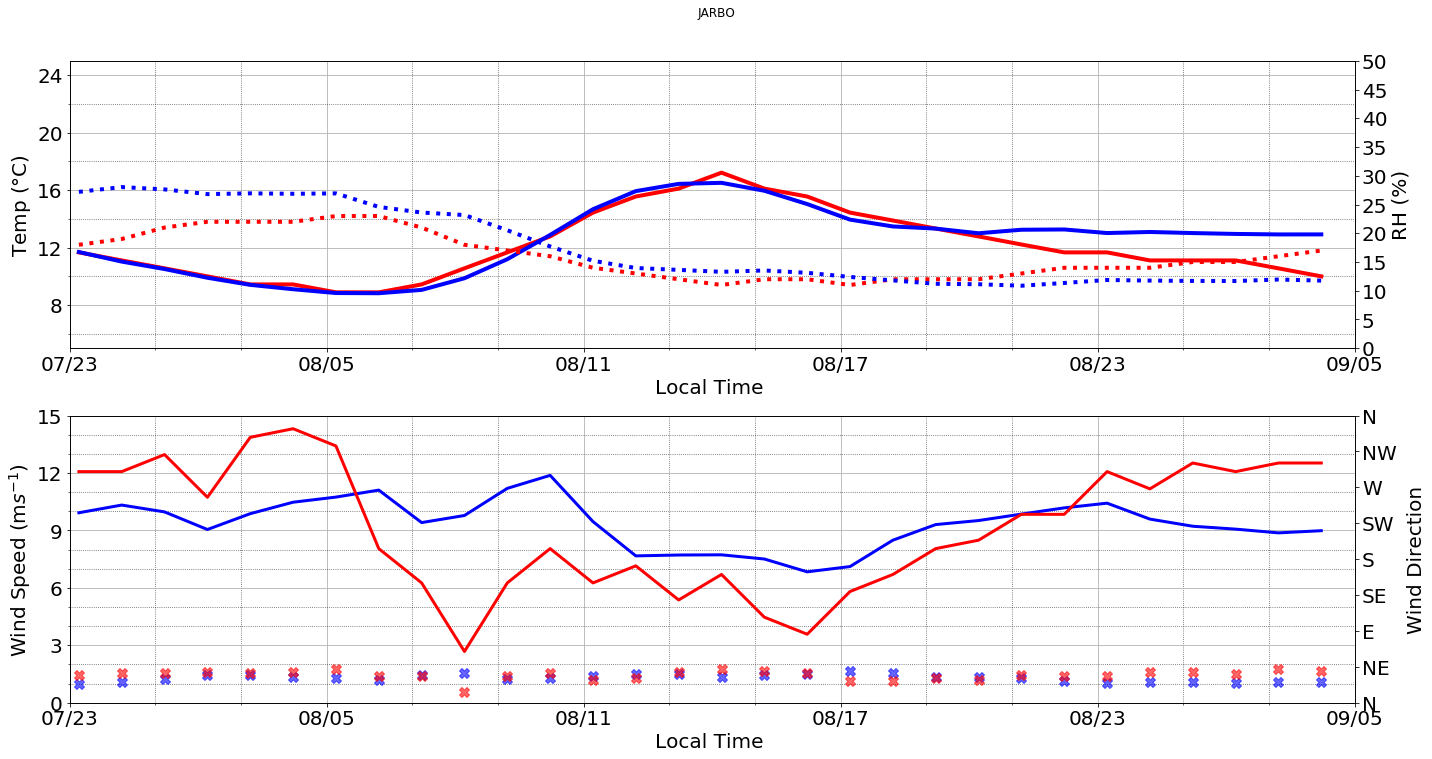

In [105]:
#######################################################################################
####### Reading in the RAWS and WRF station netcdf files with xarray ##################
#######################################################################################

jg_raws = xr.open_dataset('jarbo_gap_RAWS.nc')
jg_wrf = xr.open_dataset('/srv/home/mbrewer/wrf_out/Final_Jarbo_gap_timeseries.nc')

######## Slicing the long RAWS file to only the time period I care about.... about 6 hours into the WRF run to avoid the "spin up time"
jg_raws = jg_raws.sel(time=slice(jg_wrf.Time[0], jg_wrf.Time[-70]))
jg_wrf = jg_wrf.sel(Time=slice(jg_wrf.Time[0], jg_wrf.Time[-72]))

jg_wrf_h = jg_wrf.resample(Time='1H').mean() ### Resampling the data to one hour averages to match the RAWS data

# Calculating wind speed and direction using metpy
wspd = mpcalc.wind_speed(jg_wrf_h.u10,jg_wrf_h.v10 )   
wdir = mpcalc.wind_direction(jg_wrf_h.u10,jg_wrf_h.v10)
jg_wrf_h['wspd'] = np.array(wspd).squeeze()  ## putting these data back into the dataframe
jg_wrf_h['wdir'] = np.array(wdir).squeeze()

# I'm taking the UTC time from both the 1 hour RAWS and 10min WRF output and converting it to US/Pacific time
t = jg_wrf.Time.to_index().tz_localize('UTC').tz_convert('US/Pacific') ### Taking the 
ts = jg_raws.time.to_index().tz_localize('UTC').tz_convert('US/Pacific')


fig= plt.figure(figsize = (20,10))

ax = fig.add_subplot(211)

fig.suptitle('JARBO',x= .5, y= 1.05)

ax.plot(ts,jg_raws.temp, color = 'red', label = 'RAWS Air Temperature', linewidth = 4)
ax.plot(ts, jg_wrf_h.T2-273.15, color = 'blue', label = 'WRF 2m Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 20)
ax.set_xlabel('Local Time ', fontsize = 20)


###
ax1 = ax.twinx()
ax1.plot(ts,jg_raws.rh, ls = ':', label = 'RAWS RH', linewidth = 4, color = 'red')
ax1.plot(ts, jg_wrf_h.rh2, linestyle = ':', label = 'WRF 2m RH', linewidth = 4, color = 'blue')
ax1.set_ylabel('RH (%)', fontsize = 20)


# Setting Axis limits
ax.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 05:00:00-08:00')
ax.set_ylim(5,25)
ax1.set_ylim(0,50)

#### Setting figure legend ########
#lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2, loc=0, fontsize = 20, ncol = 2)

##### Setting font size and font type for x and y ticks #######
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


## Setting Date locators and formats
ax.xaxis.set_major_locator(dates.HourLocator(interval=6))
ax.xaxis.set_minor_locator(dates.HourLocator(interval=2))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d/%H'))
### Setting Y-axis ticks and minor ticks
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=5.0))
#setting figure grid
ax.grid()
ax.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
#############################################################################################
ax2 = fig.add_subplot(212)

ax2.plot(ts,jg_wrf_h.wspd, label = 'WRF 10m Wind Speed', ls = '-', linewidth = 3, color = 'blue')
ax2.plot(ts, jg_raws.wspd, label = 'RAWS 6m Wind Speed', ls = '-', linewidth = 3, color = 'red')
#$ax2.scatter(ts, jg_raws.wgst,  marker = 'P', s =200, label = 'Wind Gusts', color = 'red')
ax2.set_ylabel('Wind Speed (m$s^{-1}$)',fontsize = 20)
ax2.set_xlabel('Local Time ', fontsize = 20)
ax2.set_ylim(0,15)

ax3= ax2.twinx()
ax3.scatter(pd.to_datetime(ts),jg_wrf_h.wdir, marker = 'X', s=100,alpha = .6, label ='WRF Wind Direction', color = 'blue')
ax3.scatter(pd.to_datetime(ts), jg_raws.wdir, marker = 'X', s=100,alpha = .6, label ='RAWS Wind Direction', color = 'red')
### formatting the second axis to be from 0-360 then replacing the labels with directions
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 20,  labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])

#handling the legends
#lines, labels = ax2.get_legend_handles_labels()
#lines2, labels2 = ax3.get_legend_handles_labels()
#ax3.legend(lines + lines2, labels + labels2, loc=1, fontsize = 18, ncol = 2)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    

ax2.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 05:00:00-08:00')
ax2.xaxis.set_major_locator(dates.HourLocator(interval=6))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=2))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d/%H'))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 3))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 1))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))

ax2.grid()
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')

plt.tight_layout()


print('Wind speed RMSE: ' + str(rmse(jg_wrf_h.wspd.data, jg_raws.wspd.data)))
print('RH RMSE: ' +str(rmse(jg_wrf_h.rh2.data, jg_raws.rh.data)))
print('Temperature RMSE: ' +str(rmse(jg_wrf_h.T2.data-273.15, jg_raws.temp.data)))
print('Wind direction RMSE: ' + str(rmse(jg_wrf_h.wdir.data, jg_raws.wdir.data)))

plt.savefig('jarbo_v_wrf.png', dpi = 300)

/srv/home/mbrewer/anaconda3/envs/working/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Wind speed RMSE: 2.0777047796834083
RH RMSE: 10.098395808286474
Temperature RMSE: 4.839196445898381
Wind direction RMSE: 186.87589245321524


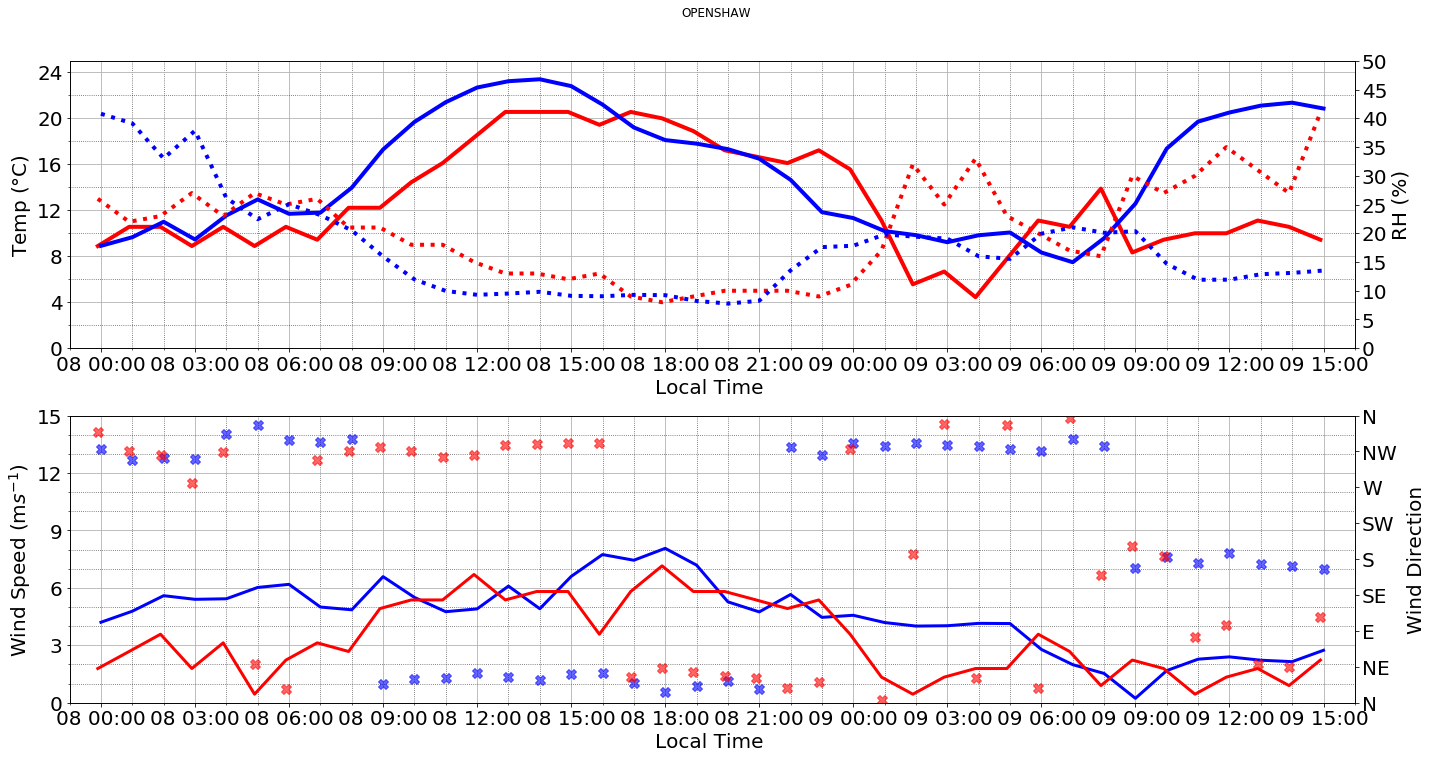

In [106]:
#######################################################################################
####### Reading in the RAWS and WRF station netcdf files with xarray ##################
#######################################################################################

os_raws = xr.open_dataset('openshaw_RAWS.nc')
os_wrf = xr.open_dataset('Final_Openshaw_timeseries.nc')

######## Slicing the long RAWS file to only the time period I care about.... about 6 hours into the WRF run to avoid the "spin up time"
os_raws = os_raws.sel(time=slice(os_wrf.Time[0], os_wrf.Time[-1]))
os_wrf = os_wrf.sel(Time=slice(os_wrf.Time[6], os_wrf.Time[-1]))

os_wrf_h = os_wrf.resample(Time='1H').mean() ### Resampling the data to one hour averages to match the RAWS data

# Calculating wind speed and direction using metpy
wspd = mpcalc.wind_speed(os_wrf_h.u10,os_wrf_h.v10 )   
wdir = mpcalc.wind_direction(os_wrf_h.u10,os_wrf_h.v10)
os_wrf_h['wspd'] = np.array(wspd).squeeze()  ## putting these data back into the dataframe
os_wrf_h['wdir'] = np.array(wdir).squeeze()

# I'm taking the UTC time from both the 1 hour RAWS and 10min WRF output and converting it to US/Pacific time
t = os_wrf_h.Time.to_index().tz_localize('UTC').tz_convert('US/Pacific') ### Taking the 
ts = os_raws.time.to_index().tz_localize('UTC').tz_convert('US/Pacific')


fig= plt.figure(figsize = (20,10))
fig.suptitle('OPENSHAW',x= .5, y= 1.05)
ax = fig.add_subplot(211)


ax.plot(ts,os_raws.temp, color = 'red', label = 'RAWS Air Temperature', linewidth = 4)
ax.plot(t, os_wrf_h.T2-273.15, color = 'blue', label = 'WRF 2m Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 20)
ax.set_xlabel('Local Time ', fontsize = 20)


###
ax1 = ax.twinx()
ax1.plot(ts,os_raws.rh, ls = ':', label = 'RAWS RH', linewidth = 4, color = 'red')
ax1.plot(t, os_wrf_h.rh2, linestyle = ':', label = 'WRF 2m RH', linewidth = 4, color = 'blue')
ax1.set_ylabel('RH (%)', fontsize = 20)


## Setting Axis limits
ax.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax.set_ylim(0,25)
ax1.set_ylim(0,50)

#### Setting figure legend ########
#lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize = 20, ncol = 2)

##### Setting font size and font type for x and y ticks #######
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


## Setting Date locators and formats
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
### Setting Y-axis ticks and minor ticks
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=5.0))
#setting figure grid
ax.grid()
ax.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
#############################################################################################
ax2 = fig.add_subplot(212)

ax2.plot(t,os_wrf_h.wspd, label = 'WRF 10m Wind Speed', ls = '-', linewidth = 3, color = 'blue')
ax2.plot(ts, os_raws.wspd, label = 'RAWS 6m Wind Speed', ls = '-', linewidth = 3, color = 'red')
#$ax2.scatter(ts, os_raws.wgst,  marker = 'P', s =200, label = 'Wind Gusts', color = 'red')
ax2.set_ylabel('Wind Speed (m$s^{-1}$)',fontsize = 20)
ax2.set_xlabel('Local Time ', fontsize = 20)
ax2.set_ylim(0,15)

ax3= ax2.twinx()
ax3.scatter(pd.to_datetime(t),os_wrf_h.wdir, marker = 'X', s=100,alpha = .6, label ='WRF Wind Direction', color = 'blue')
ax3.scatter(pd.to_datetime(ts), os_raws.wdir, marker = 'X', s=100,alpha = .6, label ='RAWS Wind Direction', color = 'red')
### formatting the second axis to be from 0-360 then replacing the labels with directions
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 20,  labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])

#handling the legends
#lines, labels = ax2.get_legend_handles_labels()
#lines2, labels2 = ax3.get_legend_handles_labels()
#ax3.legend(lines + lines2, labels + labels2, loc=0, fontsize = 18, ncol = 2)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    

ax2.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 3))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 1))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))

ax2.grid()
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')

plt.tight_layout()
#rmse(os_wrf_h.wdir, os_raws.wdir)

print('Wind speed RMSE: ' + str(rmse(os_wrf_h.wspd.data, os_raws.wspd.data)))
print('RH RMSE: ' +str(rmse(os_wrf_h.rh2.data, os_raws.rh.data)))
print('Temperature RMSE: ' +str(rmse(os_wrf_h.T2.data-273.15, os_raws.temp.data)))
print('Wind direction RMSE: ' + str(rmse(os_wrf_h.wdir.data, os_raws.wdir.data)))

plt.savefig('openshaw_v_wrf.png', dpi = 300)

/srv/home/mbrewer/anaconda3/envs/working/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Wind speed RMSE: 3.5994776721292543
RH RMSE: 4.680142681152359
Temperature RMSE: 2.6495129266760173
Wind direction RMSE: 65.49373774374823


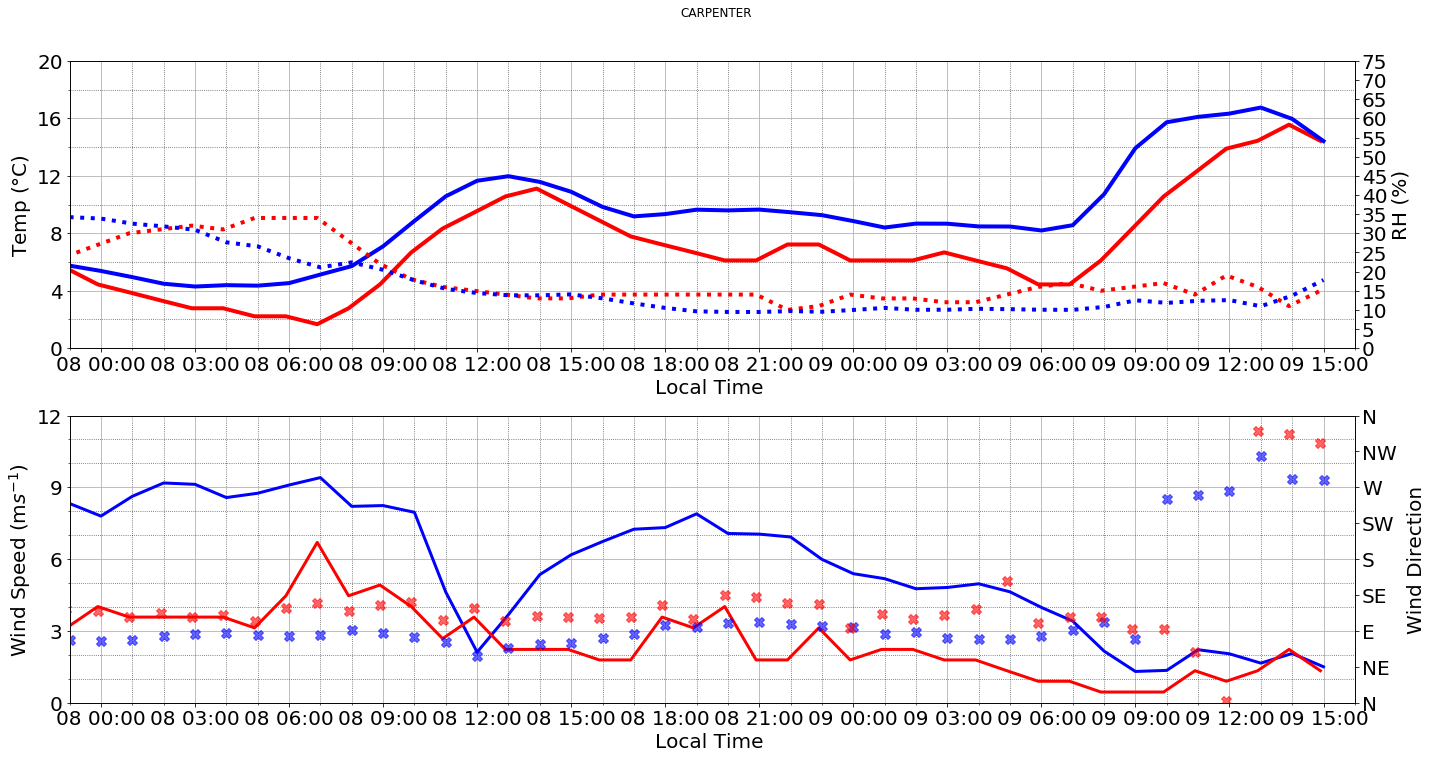

In [107]:
#######################################################################################
####### Reading in the RAWS and WRF station netcdf files with xarray ##################
#######################################################################################

cr_raws = xr.open_dataset('carpenter_ridge_RAWS.nc')
cr_wrf = xr.open_dataset('Final_Carpenter_timeseries.nc')

######## Slicing the long RAWS file to only the time period I care about.... about 6 hours into the WRF run to avoid the "spin up time"
cr_raws = cr_raws.sel(time=slice(np.array('2018-11-08T06:00:00.000000000', dtype='datetime64[ns]'), cr_wrf.Time[-1]))
cr_wrf = cr_wrf.sel(Time=slice(cr_wrf.Time[0], cr_wrf.Time[-1]))

cr_wrf_h = cr_wrf.resample(Time='1H').mean() ### Resampling the data to one hour averages to match the RAWS data

# Calculating wind speed and direction using metpy
wspd = mpcalc.wind_speed(cr_wrf_h.u10,cr_wrf_h.v10 )   
wdir = mpcalc.wind_direction(cr_wrf_h.u10,cr_wrf_h.v10)
cr_wrf_h['wspd'] = np.array(wspd).squeeze()  ## putting these data back into the dataframe
cr_wrf_h['wdir'] = np.array(wdir).squeeze()

# I'm taking the UTC time from both the 1 hour RAWS and 10min WRF output and converting it to US/Pacific time
t = cr_wrf_h.Time.to_index().tz_localize('UTC').tz_convert('US/Pacific') ### Taking the 
ts = cr_raws.time.to_index().tz_localize('UTC').tz_convert('US/Pacific')


fig= plt.figure(figsize = (20,10))
fig.suptitle('CARPENTER',x= .5, y= 1.05)
ax = fig.add_subplot(211)


ax.plot(ts,cr_raws.temp, color = 'red', label = 'RAWS Air Temperature', linewidth = 4)
ax.plot(t, cr_wrf_h.T2-273.15, color = 'blue', label = 'WRF 2m Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 20)
ax.set_xlabel('Local Time ', fontsize = 20)


###
ax1 = ax.twinx()
ax1.plot(ts,cr_raws.rh, ls = ':', label = 'RAWS RH', linewidth = 4, color = 'red')
ax1.plot(t, cr_wrf_h.rh2, linestyle = ':', label = 'WRF 2m RH', linewidth = 4, color = 'blue')
ax1.set_ylabel('RH (%)', fontsize = 20)


## Setting Axis limits
ax.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax.set_ylim(0,20)
ax1.set_ylim(0,75)

#### Setting figure legend ########
#lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize = 20, ncol = 2)

##### Setting font size and font type for x and y ticks #######
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


## Setting Date locators and formats
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
### Setting Y-axis ticks and minor ticks
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=5.0))
#setting figure grid
ax.grid()
ax.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
#############################################################################################
ax2 = fig.add_subplot(212)

ax2.plot(t,cr_wrf_h.wspd, label = 'WRF 10m Wind Speed', ls = '-', linewidth = 3, color = 'blue')
ax2.plot(ts, cr_raws.wspd, label = 'RAWS 6m Wind Speed', ls = '-', linewidth = 3, color = 'red')
#$ax2.scatter(ts, cr_raws.wgst,  marker = 'P', s =200, label = 'Wind Gusts', color = 'red')
ax2.set_ylabel('Wind Speed (m$s^{-1}$)',fontsize = 20)
ax2.set_xlabel('Local Time ', fontsize = 20)
ax2.set_ylim(0,12)

ax3= ax2.twinx()
ax3.scatter(pd.to_datetime(t),cr_wrf_h.wdir,marker = 'X', s=100,alpha = .6, label ='WRF Wind Direction', color = 'blue')
ax3.scatter(pd.to_datetime(ts), cr_raws.wdir,marker = 'X', s=100,alpha = .6, label ='RAWS Wind Direction', color = 'red')
### formatting the second axis to be from 0-360 then replacing the labels with directions
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 20,  labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])

#handling the legends
#lines, labels = ax2.get_legend_handles_labels()
#lines2, labels2 = ax3.get_legend_handles_labels()
#ax3.legend(lines + lines2, labels + labels2, loc=0, fontsize = 18, ncol = 2)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    

ax2.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 3))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 1))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))

ax2.grid()
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')

plt.tight_layout()
#rmse(cr_wrf_h.wdir, cr_raws.wdir)

print('Wind speed RMSE: ' + str(rmse(cr_wrf_h.wspd.data, cr_raws.wspd.data)))
print('RH RMSE: ' +str(rmse(cr_wrf_h.rh2.data, cr_raws.rh.data)))
print('Temperature RMSE: ' +str(rmse(cr_wrf_h.T2.data-273.15, cr_raws.temp.data)))
print('Wind direction RMSE: ' + str(rmse(cr_wrf_h.wdir.data, cr_raws.wdir.data)))

plt.savefig('carpenter_v_wrf.png', dpi = 300)

/srv/home/mbrewer/anaconda3/envs/working/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Wind speed RMSE: 6.8010865252906285
Wind speed/gust RMSE: 3.724297613976693
RH RMSE: 4.431301921114584
Temperature RMSE: 1.7882861344890477
Wind direction RMSE: 88.51668098434612


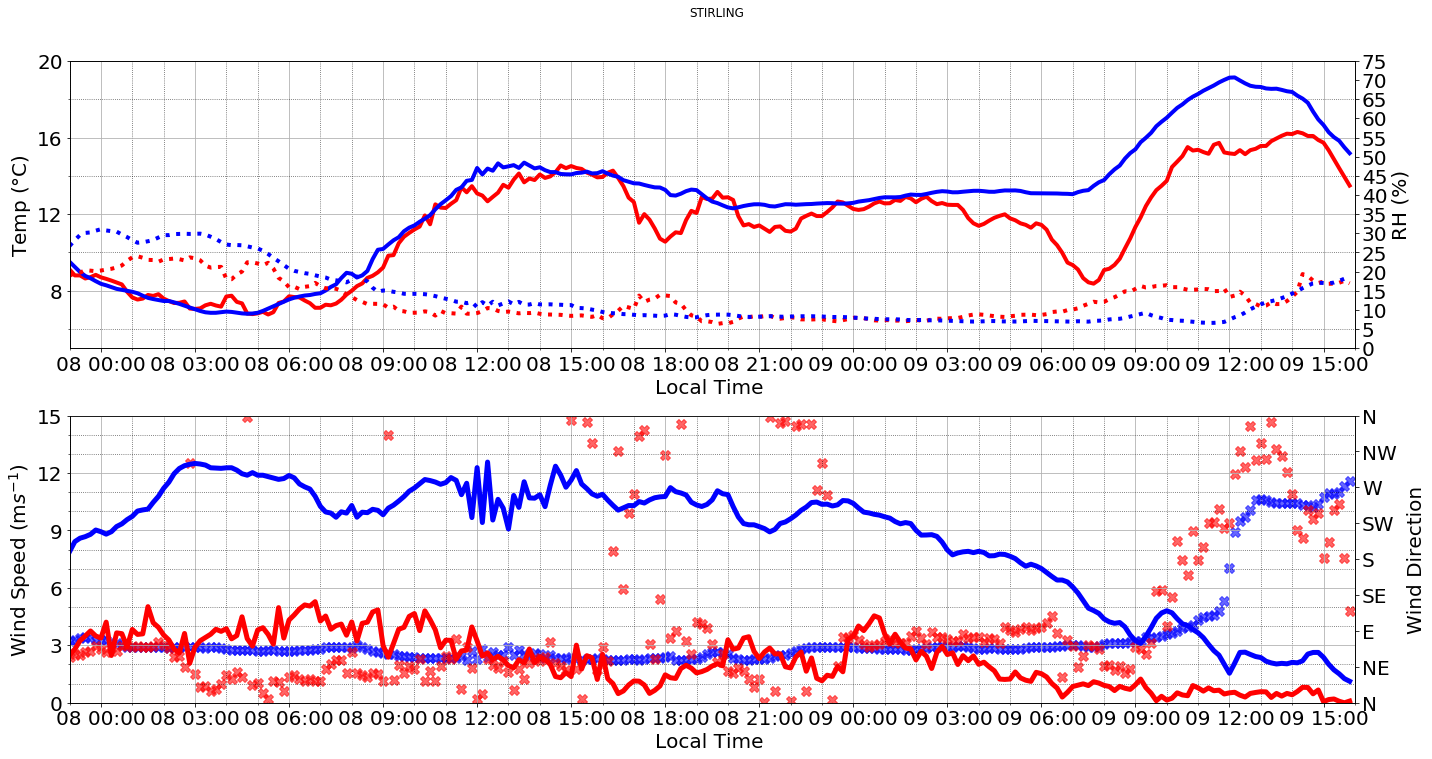

In [108]:
#######################################################################################
####### Reading in the RAWS and WRF station netcdf files with xarray ##################
#######################################################################################

sc_raws = xr.open_dataset('sterling_city_RAWS.nc')
sc_wrf = xr.open_dataset('Final_stirling_city_timeseries.nc')

######## Slicing the long RAWS file to only the time period I care about.... about 6 hours into the WRF run to avoid the "spin up time"
sc_raws = sc_raws.sel(time=slice(sc_wrf.Time[0], sc_wrf.Time[-1]))
sc_wrf = sc_wrf.sel(Time=slice(sc_wrf.Time[0], sc_wrf.Time[-1]))

sc_raws.wspd.values[193] = (sc_raws.wspd.values[194]+sc_raws.wspd.values[192])/2
sc_raws.wdir.values[-2] = (sc_raws.wdir.values[-1]+sc_raws.wdir.values[-3])/2

# Calculating wind speed and direction using metpy
wspd = mpcalc.wind_speed(sc_wrf.u10*units('m/s'),sc_wrf.v10*units('m/s') )   
wdir = mpcalc.wind_direction(sc_wrf.u10*units('m/s'),sc_wrf.v10*units('m/s'))
sc_wrf['wspd'] = np.array(wspd).squeeze()  ## putting these data back into the dataframe
sc_wrf['wdir'] = np.array(wdir).squeeze()

# I'm taking the UTC time from both the 1 hour RAWS and 10min WRF output and converting it to US/Pacific time
t = sc_wrf.Time.to_index().tz_localize('UTC').tz_convert('US/Pacific') ### Taking the 
ts = sc_raws.time.to_index().tz_localize('UTC').tz_convert('US/Pacific')


fig= plt.figure(figsize = (20,10))
fig.suptitle('STIRLING',x= .5, y= 1.05)
ax = fig.add_subplot(211)


ax.plot(ts,sc_raws.temp, color = 'red', label = 'RAWS Air Temperature', linewidth = 4)
ax.plot(t, sc_wrf.T2-273.15, color = 'blue', label = 'WRF 2m Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 20)
ax.set_xlabel('Local Time ', fontsize = 20)


###
ax1 = ax.twinx()
ax1.plot(ts,sc_raws.rh, ls = ':', label = 'RAWS RH', linewidth = 4, color = 'red')
ax1.plot(t, sc_wrf.rh2, linestyle = ':', label = 'WRF 2m RH', linewidth = 4, color = 'blue')
ax1.set_ylabel('RH (%)', fontsize = 20)


## Setting Axis limits
ax.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax.set_ylim(5,20)
ax1.set_ylim(0,75)

#### Setting figure legend ########
#lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize = 20, ncol = 2)

##### Setting font size and font type for x and y ticks #######
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


## Setting Date locators and formats
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
### Setting Y-axis ticks and minor ticks
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=5.0))
#setting figure grid
ax.grid()
ax.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
#############################################################################################
ax2 = fig.add_subplot(212)

ax2.plot(t,sc_wrf.wspd, label = 'WRF 10m Wind Speed', ls = '-', linewidth = 5, color = 'blue')
ax2.plot(ts, sc_raws.wspd, label = 'RAWS 6m Wind Speed', ls = '-', linewidth = 5, color = 'red')
#ax2.scatter(ts, sc_raws.wgst,  marker = 'P', s =200, label = 'Wind Gusts', color = 'red')
ax2.set_ylabel('Wind Speed (m$s^{-1}$)',fontsize = 20)
ax2.set_xlabel('Local Time ', fontsize = 20)
ax2.set_ylim(0,15)

ax3= ax2.twinx()
ax3.scatter(pd.to_datetime(t),sc_wrf.wdir, marker = 'X', s=100,alpha = .6, label ='WRF Wind Direction', color = 'blue')
ax3.scatter(pd.to_datetime(ts), sc_raws.wdir, marker = 'X', s=100,alpha = .6, label ='RAWS Wind Direction', color = 'red')
### formatting the second axis to be from 0-360 then replacing the labels with directions
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 20,  labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])

#handling the legends
#lines, labels = ax2.get_legend_handles_labels()
#lines2, labels2 = ax3.get_legend_handles_labels()
#ax3.legend(lines + lines2, labels + labels2, loc=0, fontsize = 18, ncol = 2)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    

ax2.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 3))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 1))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))

ax2.grid()
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')

plt.tight_layout()
#rmse(sc_wrf_h.wdir, sc_raws.wdir)
ax2.set_zorder(10)
ax2.patch.set_visible(False)
ax3.patch.set_visible(True)

print('Wind speed RMSE: ' + str(rmse(sc_wrf.wspd.data, sc_raws.wspd.data)))
print('Wind speed/gust RMSE: ' + str(rmse(sc_wrf.wspd.data, sc_raws.wgst.data)))
print('RH RMSE: ' +str(rmse(sc_wrf.rh2.data, sc_raws.rh.data)))
print('Temperature RMSE: ' +str(rmse(sc_wrf.T2.data-273.15, sc_raws.temp.data)))
print('Wind direction RMSE: ' + str(rmse(sc_wrf.wdir.data, sc_raws.wdir.data)))

plt.savefig('stirling_v_wrf.png', dpi = 300)

/srv/home/mbrewer/anaconda3/envs/working/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


Wind speed RMSE: 2.3847398859711757
RH RMSE: 6.752707215593411
Temperature RMSE: 3.705536687201822
Wind direction RMSE: 17.12139889103185


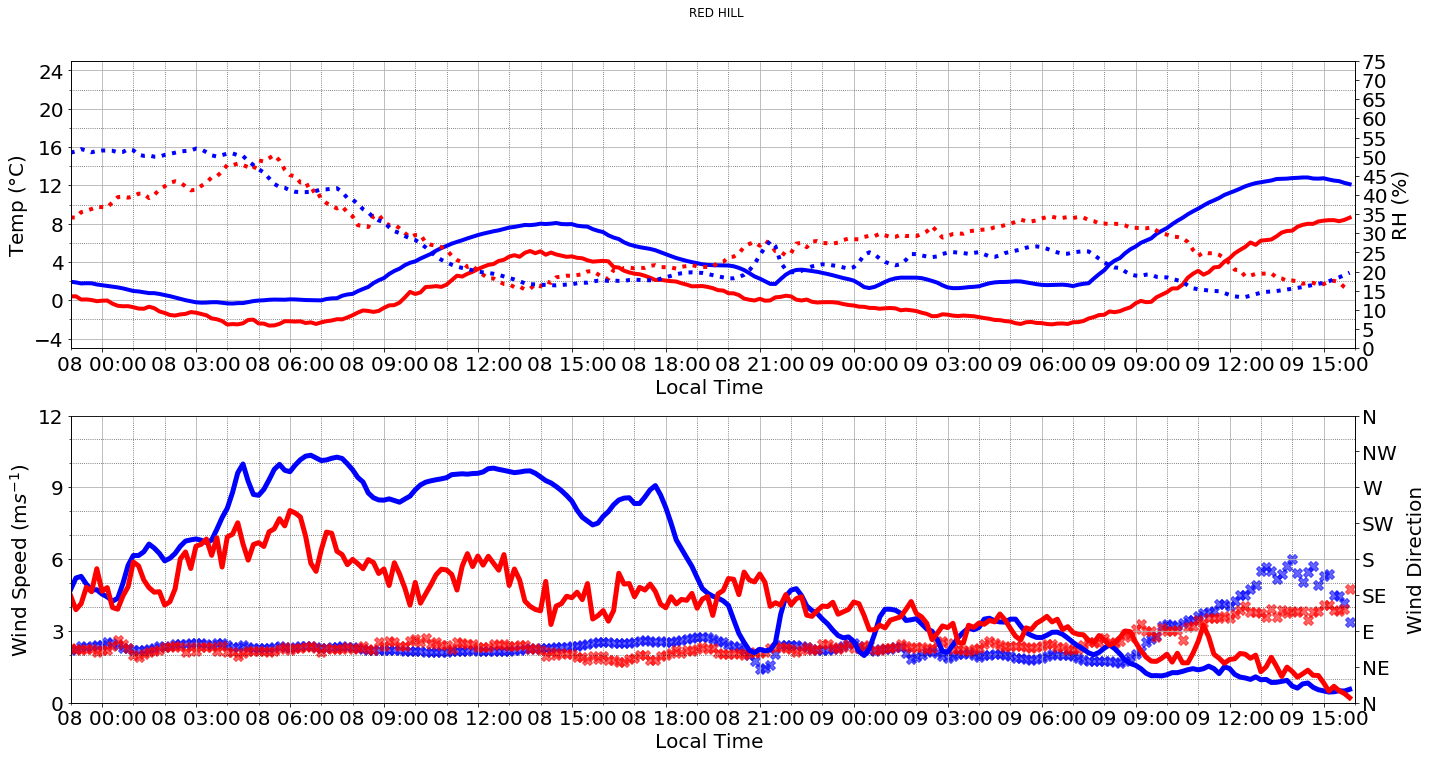

In [109]:
#######################################################################################
####### Reading in the RAWS and WRF station netcdf files with xarray ##################
#######################################################################################

rh_raws = xr.open_dataset('PG129_Red_Hill_Lookout_RAWS.nc')
rh_wrf = xr.open_dataset('Final_PG129_timeseries.nc')


######## Slicing the long RAWS file to only the time period I care about.... about 6 hours into the WRF run to avoid the "spin up time"
rh_raws = rh_raws.sel(time=slice(rh_wrf.Time[0], rh_wrf.Time[-1]))
rh_wrf = rh_wrf.sel(Time=slice(rh_wrf.Time[0], rh_wrf.Time[-1]))


# Calculating wind speed and direction using metpy
wspd = mpcalc.wind_speed(rh_wrf.u10*units('m/s'),rh_wrf.v10*units('m/s') )   
wdir = mpcalc.wind_direction(rh_wrf.u10*units('m/s'),rh_wrf.v10*units('m/s'))
rh_wrf['wspd'] = np.array(wspd).squeeze()  ## putting these data back into the dataframe
rh_wrf['wdir'] = np.array(wdir).squeeze()

# I'm taking the UTC time from both the 1 hour RAWS and 10min WRF output and converting it to US/Pacific time
t = rh_wrf.Time.to_index().tz_localize('UTC').tz_convert('US/Pacific') ### Taking the 
ts = rh_raws.time.to_index().tz_localize('UTC').tz_convert('US/Pacific')


fig= plt.figure(figsize = (20,10))
fig.suptitle('RED HILL',x= .5, y= 1.05)
ax = fig.add_subplot(211)


ax.plot(ts,rh_raws.temp, color = 'red', label = 'RAWS Air Temperature', linewidth = 4)
ax.plot(t, rh_wrf.T2-273.15, color = 'blue', label = 'WRF 2m Air Temperature', linewidth = 4)
ax.set_ylabel('Temp ($\degree$C)', fontsize = 20)
ax.set_xlabel('Local Time ', fontsize = 20)


###
ax1 = ax.twinx()
ax1.plot(ts,rh_raws.rh, ls = ':', label = 'RAWS RH', linewidth = 4, color = 'red')
ax1.plot(t, rh_wrf.rh2, linestyle = ':', label = 'WRF 2m RH', linewidth = 4, color = 'blue')
ax1.set_ylabel('RH (%)', fontsize = 20)


## Setting Axis limits
ax.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax.set_ylim(-5,25)
ax1.set_ylim(0,75)

#### Setting figure legend ########
#lines, labels = ax.get_legend_handles_labels()
#lines2, labels2 = ax1.get_legend_handles_labels()
#ax1.legend(lines + lines2, labels + labels2, loc=2, fontsize = 20, ncol = 2)

##### Setting font size and font type for x and y ticks #######
for label in (ax.get_xticklabels() + ax.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax1.get_xticklabels() + ax1.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    


## Setting Date locators and formats
ax.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))
### Setting Y-axis ticks and minor ticks
ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 4))
ax.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 2))
ax1.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=5.0))
#setting figure grid
ax.grid()
ax.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')
#############################################################################################
ax2 = fig.add_subplot(212)

ax2.plot(t,rh_wrf.wspd, label = 'WRF 10m Wind Speed', ls = '-', linewidth = 5, color = 'blue')
ax2.plot(ts, rh_raws.wspd, label = 'RAWS 6m Wind Speed', ls = '-', linewidth = 5, color = 'red')
#ax2.scatter(ts, rh_raws.wgst,  marker = 'P', s =200, label = 'Wind Gusts', color = 'red')
ax2.set_ylabel('Wind Speed (m$s^{-1}$)',fontsize = 20)
ax2.set_xlabel('Local Time ', fontsize = 20)
ax2.set_ylim(0,12)

ax3= ax2.twinx()
ax3.scatter(pd.to_datetime(t),rh_wrf.wdir, marker = 'X', s=100,alpha = .6, label ='WRF Wind Direction', color = 'blue')
ax3.scatter(pd.to_datetime(ts), rh_raws.wdir, marker = 'X', s=100, label ='RAWS Wind Direction', color = 'red', alpha = .6)
### formatting the second axis to be from 0-360 then replacing the labels with directions
ax3.set_ylim(0,360)
ax3.set_ylabel('Wind Direction', fontsize = 20,  labelpad = 10)
ax3.set_yticklabels(["",'N',"NE", "E", "SE", "S", "SW", "W", "NW", "N"])

#handling the legends
#lines, labels = ax2.get_legend_handles_labels()
#lines2, labels2 = ax3.get_legend_handles_labels()
#ax3.legend(lines + lines2, labels + labels2, loc=0, fontsize = 18, ncol = 2)


for label in (ax2.get_xticklabels() + ax2.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20);
for label in (ax3.get_xticklabels() + ax3.get_yticklabels()):
    label.set_fontname('Arial')
    label.set_fontsize(20)
    

ax2.set_xlim('2018-11-07 23:00:00-08:00', '2018-11-09 16:00:00-08:00')
ax2.xaxis.set_major_locator(dates.HourLocator(interval=3))
ax2.xaxis.set_minor_locator(dates.HourLocator(interval=1))
ax2.xaxis.set_major_formatter(dates.DateFormatter('%d %H:%M'))

ax2.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base = 3))
ax2.yaxis.set_minor_locator(mpl.ticker.MultipleLocator(base = 1))
ax3.yaxis.set_major_locator(mpl.ticker.MultipleLocator(base=45.0))

ax2.grid()
ax2.grid(which = 'minor',color = 'k', alpha = .7, ls = ':')

plt.tight_layout()
#rmse(rh_wrf_h.wdir, rh_raws.wdir)
ax2.set_zorder(10)
ax2.patch.set_visible(False)
ax3.patch.set_visible(True)
print('Wind speed RMSE: ' + str(rmse(rh_wrf.wspd.data, rh_raws.wspd.data)))
print('RH RMSE: ' +str(rmse(rh_wrf.rh2.data, rh_raws.rh.data)))
print('Temperature RMSE: ' +str(rmse(rh_wrf.T2.data-273.15, rh_raws.temp.data)))
print('Wind direction RMSE: ' + str(rmse(rh_wrf.wdir.data, rh_raws.wdir.data)))

plt.savefig('redhill_v_wrf.png', dpi = 300)

In [110]:
import sys
print(sys.executable)

/srv/home/mbrewer/anaconda3/envs/working/bin/python
